In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split
import gc
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
trained_model_path = "./trained_models/ResNet-v3.pth"

SEED = 42
TEST_SIZE = 0.3
VALIDATION_SIZE = 0.1


# Flags
OPTIMIZE_HYPERPARAMETERS = False
LOAD_TRAINED_MODEL = True
TRAIN_MODEL = False

cuda


## Load the data into DataLoader
In this step, data is reshaped and normalized
- Normalization helps eliminate the effects of lighting (brightness, contrast, etc.) and other factors that may affect the image, leading to better training performance.


In [2]:
def data_loader(data_path, batch_size, random_seed=SEED, validation_size=VALIDATION_SIZE, test_size=TEST_SIZE, shuffle=True):
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
    ])

    dataset = datasets.ImageFolder(data_path, transform=transform)

    train_data, test_data = random_split(dataset, [1-test_size, test_size])

    # load the dataset
    training_dataset = train_data 
    validation_dataset = train_data

    num_train = len(training_dataset)
    indices = list(range(num_train))
    split = int(np.floor(validation_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=batch_size, sampler=train_sampler)

    validation_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=batch_size, sampler=valid_sampler)

    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle)
    
    return (training_loader, validation_loader, test_loader)

dataset_path = "./datasets/Colorectal Cancer"

training_loader, test_loader, test_loader = data_loader(data_path=dataset_path, batch_size=64, test_size=0.3)

## Model Definition
This section contains the definitions for the ResNET model

In [3]:
from itertools import product


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()

        # convolutional layers
        self.convolution_layer_1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.convolution_layer_2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))

        self.downsample = downsample
        
        # activation function
        self.relu = nn.ReLU()

        # numebr of output layers
        self.out_channels = out_channels

    def forward(self, x):
        residual = x

        output = self.convolution_layer_1(x)
        output = self.convolution_layer_2(output)

        if self.downsample:
            residual = self.downsample(x)

        output += residual
        output = self.relu(output)

        return output
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64

        self.convolutional_layer_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.max_pooling = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer0 = self._generate_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._generate_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._generate_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._generate_layer(block, 512, layers[3], stride = 2)

        self.average_pooling = nn.AvgPool2d(7, stride=1)

        self.fully_connected = nn.Linear(512, num_classes)

    def _generate_layer(self, block, planes, blocks, stride=1):
        downsample = None

        # downsample when the width/height of the output is smaller than the input or the stride is > 1
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.convolutional_layer_1(x)
        x = self.max_pooling(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.average_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)

        return x

## Finding best hyperparameter values by performing a grid search

In [4]:
# Grid search parameters
batch_sizes = [16, 32, 64, 128]
learning_rates = [0.001, 0.01, 0.05, 0.1]

learning_rate = 0.01
momentum = 0.9
weight_decay = 0.001
num_epochs = 30

if OPTIMIZE_HYPERPARAMETERS:
    grid_search_results = {}

    criterion = nn.CrossEntropyLoss()

    # Perform grid search
    for bs, lr in product(batch_sizes, learning_rates):
        print(f"\nTraining with batch_size={bs}, learning_rate={lr}")
        
        # Update parameters
        batch_size = bs
        learning_rate = lr
        
        # Reinitialize model and optimizer
        model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
        optimizer = torch.optim.SGD(model.parameters(), 
                                    lr=learning_rate,
                                    momentum=momentum,
                                    weight_decay=weight_decay)
        
        # Training loop
        train_losses = []
        validation_losses = []
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for i, (images, labels) in enumerate(training_loader):
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                del images, labels, outputs
            
            # Calculate average training loss for epoch
            train_epoch_loss = running_loss / len(training_loader)
            train_losses.append(train_epoch_loss)
            
            # Calculate validation loss
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()
            
            val_epoch_loss = val_running_loss / len(test_loader)
            validation_losses.append(val_epoch_loss)
            
            if (epoch + 1) % 5 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')
        
        # Plot training vs validation loss
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
        plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training vs Validation Loss (batch_size={bs}, learning_rate={lr})')
        plt.legend()
        plt.show()
        
        # Store results
        grid_search_results[(bs, lr)] = min(validation_losses)

    # Plot grid search results
    plt.figure(figsize=(10, 8))
    for bs in batch_sizes:
        val_losses = [grid_search_results[(bs, lr)] for lr in learning_rates]
        plt.plot(learning_rates, val_losses, label=f'Batch Size {bs}')

    plt.xlabel('Learning Rate')
    plt.ylabel('Best Validation Loss')
    plt.title('Grid Search Results: Learning Rate vs Validation Loss')
    plt.legend()
    plt.xscale('log')
    plt.grid(True)
    plt.show()

    # Find best parameters
    best_params = min(grid_search_results.items(), key=lambda x: x[1])
    print(f"\nBest parameters: batch_size={best_params[0][0]}, learning_rate={best_params[0][1]}")
    print(f"Best validation loss: {best_params[1]:.4f}")

    # batch_size = best_params[0][0]
    # learning_rate = best_params[0][1]


## Training the Model

In [5]:
## Training the Model
batch_size = 32
num_epochs = 30
learning_rate = 0.01

model = ResNet(ResidualBlock, [2, 4, 6, 3]).to(device)

if LOAD_TRAINED_MODEL:
    model.load_state_dict(torch.load(trained_model_path))

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay, momentum = momentum)  

#Train the model
total_step = len(training_loader)

train_validation_loss = []

if not LOAD_TRAINED_MODEL:
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(training_loader):  
        # move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backpropagate and update weights 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
        # free up memory that is no longer in use 
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

      # Validation
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in test_loader:
              # move tensors to device
              images = images.to(device)
              labels = labels.to(device)

              # get predictions
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)

              # update total and correct
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

              # free up memory
              del images, labels, outputs

          print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), 100 * correct / total)) 
  
      # Calculate and store training loss
      train_loss = 0.0
      with torch.no_grad():
          for images, labels in training_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              train_loss += criterion(outputs, labels).item()
              del images, labels, outputs
          train_loss /= len(training_loader)
          
      # Calculate and store validation loss  
      test_loss = 0.0
      with torch.no_grad():
          for images, labels in test_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              test_loss += criterion(outputs, labels).item()
              del images, labels, outputs
          test_loss /= len(test_loader)
          
      train_validation_loss.append({"train": train_loss, "test": test_loss})

  # Plot training and validation loss
  plt.figure(figsize=(10, 6))
  epochs = range(1, len(train_validation_loss) + 1)
  train_losses = [x["train"] for x in train_validation_loss]
  val_losses = [x["test"] for x in train_validation_loss]
  
  # Calculate mean and std for both losses
  train_mean, train_std = np.mean(train_losses), np.std(train_losses)
  val_mean, val_std = np.mean(val_losses), np.std(val_losses)

  # Filter data within 2 standard deviations
  train_mask = np.abs(train_losses - train_mean) <= 2 * train_std
  val_mask = np.abs(val_losses - val_mean) <= 2 * val_std

  # Plot filtered data
  plt.plot(np.array(epochs)[train_mask], np.array(train_losses)[train_mask], 
           color="blue", label='Training Loss')
  plt.plot(np.array(epochs)[val_mask], np.array(val_losses)[val_mask], 
           color="orange", label='Test Loss')
  plt.title('Training and Test Loss over Epochs (Within 2σ)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  torch.save(model.state_dict(), trained_model_path)  

C:\Users\kazad\AppData\Local\Temp\ipykernel_17300\1886036272.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_model_path))


## Test the model

In [6]:
if TRAIN_MODEL:
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in test_loader:
            # move tensors to device
            images = images.to(device)
            labels = labels.to(device)

            # get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # update total and correct
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # free up memory    
            del images, labels, outputs

        print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), 100 * correct / total))   

## Feature Extraction of the trained encoder

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import matplotlib.colors as mcolors

# feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

feature_extractor = FeatureExtractor(model).to(device)
feature_extractor.eval()

# Collect preencoded and encoded features
preencoded_features = []
encoded_features = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        
        preencoded = images.view(images.size(0), -1).cpu().numpy()
        preencoded_features.append(preencoded)
        
        encoded = feature_extractor(images).cpu().numpy()
        encoded_features.append(encoded)
        
        labels_list.append(labels.numpy())
        
        del images, encoded
        torch.cuda.empty_cache()

# Concatenate features and labels
preencoded_features = np.concatenate(preencoded_features)
encoded_features = np.concatenate(encoded_features)
labels_list = np.concatenate(labels_list)

tsne_2d = TSNE(n_components=2, random_state=42)
tsne_3d = TSNE(n_components=3, random_state=42)

encoded_tsne_2d = tsne_2d.fit_transform(encoded_features)
encoded_tsne_3d = tsne_3d.fit_transform(encoded_features)

preencoded_tsne_2d = tsne_2d.fit_transform(preencoded_features)
preencoded_tsne_3d = tsne_3d.fit_transform(preencoded_features)


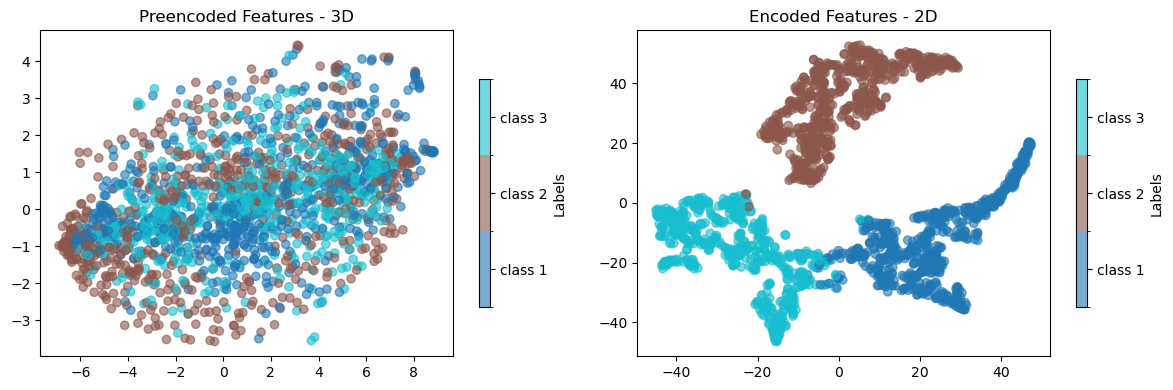

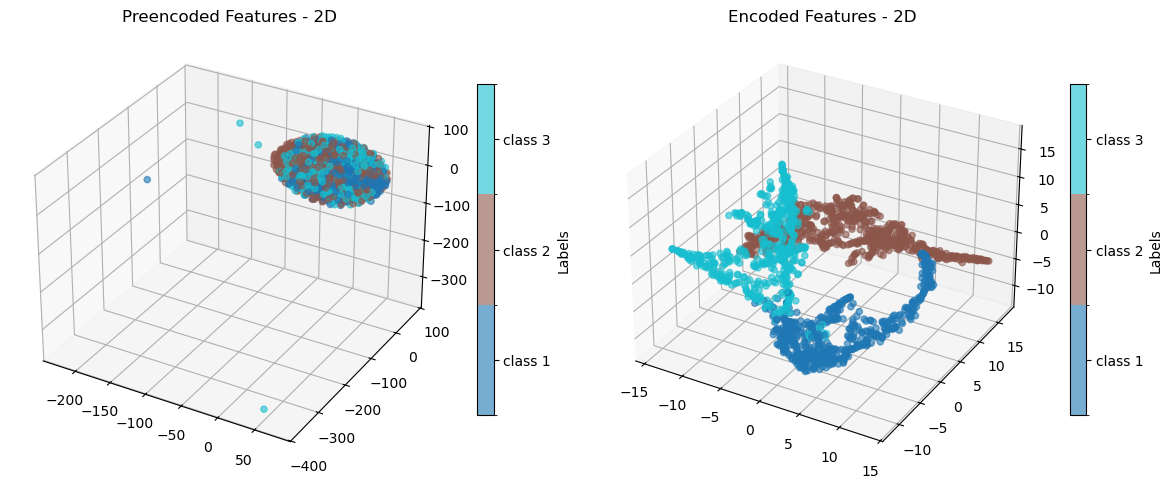

In [8]:
def plot_tsne_2d(preencoded, encoded, labels, axes, label_tags=["class 1", "class 2", "class 3"]):
    # Define a discrete colormap with boundaries based on unique labels
    unique_labels = np.unique(labels)
    cmap = plt.get_cmap('tab10', len(unique_labels))
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(unique_labels) + 1) - 0.5, ncolors=len(unique_labels))

    scatter1 = axes[0].scatter(preencoded[:, 0], preencoded[:, 1], c=labels, cmap=cmap, norm=norm, alpha=0.6)
    axes[0].set_title(f'Preencoded Features - 3D')
    cbar1 = fig.colorbar(scatter1, ax=axes[0], shrink=0.7, ticks=unique_labels)
    cbar1.set_label('Labels')
    cbar1.set_ticks(unique_labels)
    cbar1.set_ticklabels(label_tags)


    scatter2 = axes[1].scatter(encoded[:, 0], encoded[:, 1], c=labels, cmap=cmap, norm=norm, alpha=0.6)
    axes[1].set_title(f'Encoded Features - 2D')
    cbar2 = fig.colorbar(scatter2, ax=axes[1], shrink=0.7, ticks=unique_labels)
    cbar2.set_label('Labels')
    cbar2.set_ticks(unique_labels)
    cbar2.set_ticklabels(label_tags)


def plot_tsne_3d(preencoded, encoded, labels, label_tags=["class 1", "class 2", "class 3"]):
    # Define a discrete colormap with boundaries based on unique labels
    unique_labels = np.unique(labels)
    cmap = plt.get_cmap('tab10', len(unique_labels))
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(unique_labels) + 1) - 0.5, ncolors=len(unique_labels))

    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    scatter1 = ax1.scatter(preencoded[:, 0], preencoded[:, 1], preencoded[:, 2], c=labels, cmap=cmap, norm=norm, alpha=0.6)
    ax1.set_title(f'Preencoded Features - 2D')
    cbar1 = fig.colorbar(scatter1, ax=ax1, shrink=0.7, ticks=unique_labels)
    cbar1.set_label('Labels')
    cbar1.set_ticks(unique_labels)
    cbar1.set_ticklabels(label_tags)

    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    scatter2 = ax2.scatter(encoded[:, 0], encoded[:, 1], encoded[:, 2], c=labels, cmap=cmap, norm=norm, alpha=0.6)
    ax2.set_title(f'Encoded Features - 2D')
    cbar2 = fig.colorbar(scatter2, ax=ax2, shrink=0.7, ticks=unique_labels)
    cbar2.set_label('Labels')
    cbar2.set_ticks(unique_labels)
    cbar2.set_ticklabels(label_tags)


# label_tags = ["MUS", "NORM", "STR"]

# Plot side-by-side t-SNE visualizations
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_tsne_2d(preencoded_tsne_2d, encoded_tsne_2d, labels_list, axs)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 10))
plot_tsne_3d(preencoded_tsne_3d, encoded_tsne_3d, labels_list)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.show()